In [1]:
# load myodec functions
from myodec import *

In [2]:
# EMG decomposition quality thresholds
SIL_THRESH = 0.9
PNR_THRESH = 10
CoV_THRESH = 2

# Minimum number of spikes a Motor Unit Spike Train (MUST) must have (and meet quality thresholds) to be considered
MIN_PEAKS_SRC = 30

# Number of BSS sources/motor units (MUs) to attempt to extract
# Decomposition on splines can demonstrate slower convergence in the starting iterations, scales with SPLINE_DEGREE
N_COMPONENTS = 300 # <--- TIME SCALES with this parameter
# Maximum iterations for each MU detection attempt
N_ITERATIONS = 100 # <--- TIME SCALES with this parameter

# Cutoff frequencies for the bandpass filter
apply_butterworth_filter = True
lowcut, highcut = 30, 400

# Whether to try and remove powerline interference with a notch filter
# frequency estimated from frequency histogram
apply_notch_filter = True

# Wavelet based EMG filter
apply_wavelet_filter = False

# Standardize data before extension
apply_zscore = True

# Minimum number of spikes for a cluster to be considered a valid, belonging to MU when separated from the main density of spikes
MIN_STANDALONE = MIN_PEAKS_SRC
# Distance threshold (in standard deviations of sampling frequency) for identifying outlier MU clusters
SENSITIVITY_STANDALONE = 1.5


# MUs are considered identical if their MUSTs overlap by 30% (+-1 ts)
DROP_ROA = 0.3

# Clustering method for peak segmentation
cluster_method = 'k-means'

# Methods for extending the signal: "extend", "spline", or "none"
extension_method = 'spline'
apply_extension = True



# <------------------------------------------------------------------>
# Extension number, or analogously, the degree for the spline method
NUM_EXTEND = SPLINE_DEGREE = 12 # <--- TIME SCALES with this parameter, but so the resolution of BSS feature space!
# <------------------------------------------------------------------>



# Solver for the whitening step: "eigh" or "svd"
WHITEN_SOLVER = 'eigh'

# EMG sampling frequency (Hz)
# The force channel must be at the same frequency before analysis, resample if required
FS = 2222

# Set to True if the first channel in your data is a force channel
# If False, 1st column in your data will not be dropped
FORCE_CHANNEL_FIRST = True

In [3]:
results_save_path = 'decomposition-results/'
os.makedirs(results_save_path, exist_ok=True)

In [4]:
# myodec expects data in the following format:

# If FORCE_CHANNEL_FIRST = False: [EMG channels]
# If FORCE_CHANNEL_FIRST = True: [force channel] + [EMG channels]

# Load example data
emg_data = pd.read_csv('test_data/test.csv.gz')
# This dataset contains a force channel followed by 4 EMG channels (FORCE_CHANNEL_FIRST = True)
emg_data.head(2)

,Analog Input adapter 3: Analog.A 3,R VASTUS LATERALIS: dEMG.A 1,R VASTUS LATERALIS: dEMG.B 1,R VASTUS LATERALIS: dEMG.C 1,R VASTUS LATERALIS: dEMG.D 1
0,0.089929,1.856152e-20,3.669138e-21,-1.321969e-20,1.726653e-21
1,0.089122,9.712425e-21,8.741183e-21,-1.165491e-20,2.223066e-20


In [5]:
# If the EMG data is padded with zeros for any reason, one can drop them and resample channels to align:
emg_data = drop_nan_align(emg_data)
emg_data.head(2)

,Analog Input adapter 3: Analog.A 3,R VASTUS LATERALIS: dEMG.A 1,R VASTUS LATERALIS: dEMG.B 1,R VASTUS LATERALIS: dEMG.C 1,R VASTUS LATERALIS: dEMG.D 1
0,0.089929,1.467655e-20,1.251824e-20,-2.298607e-20,-9.712425e-21
1,0.089122,3.841804e-20,-2.589980e-21,-3.075601e-20,4.079219e-20


In [6]:
# The EMG data should be detached from the force channel before decomposition, and the absolute mean signal amplitude (AMS, similar to RMS) should be computed
emg_data, FORCE_CHANNEL, AMS = detach_force_channel_or_estimate_get_ams(emg_data, FORCE_CHANNEL_FIRST, FS)

# only sEMG data left
emg_data.head(2)

,R VASTUS LATERALIS: dEMG.A 1,R VASTUS LATERALIS: dEMG.B 1,R VASTUS LATERALIS: dEMG.C 1,R VASTUS LATERALIS: dEMG.D 1
0,1.467655e-20,1.251824e-20,-2.298607e-20,-9.712425e-21
1,3.841804e-20,-2.589980e-21,-3.075601e-20,4.079219e-20


In [7]:
# Apply various filters to EMG data; returns EMG data array (transposed emg_data DataFrame)
emg_signals = apply_bandpass_notch(emg_data,
                                   apply_butterworth_filter,
                                   apply_notch_filter,
                                   apply_wavelet_filter,
                                   lowcut,
                                   highcut,
                                   FS)

# save some filtered data for figures
DATA_FILTERED = copy.deepcopy(emg_signals)

CH, TS = emg_signals.shape
CH, TS

(4, 514393)

In [8]:
# Extend EMG data using classic extension or spline extension
emg_signals = get_extend(emg_signals, apply_zscore, apply_extension, extension_method, SPLINE_DEGREE)
emg_signals.shape

(44, 514393)

In [9]:
# Whitening: decorrelate the data
emg_signals = whiten(emg_signals, WHITEN_SOLVER)

In [10]:
# Run FastICA decomposition
# Returns FastICA weights, a list of dictionaries with recovered sources with their metrics, and local convergence statistics
WEIGHTS, SOURCES_INFO, DCR = fastICA(emg_signals,
                                    N_COMPONENTS,
                                    sil_thresh=SIL_THRESH,
                                    pnr_thresh=PNR_THRESH,
                                    cov_thresh=CoV_THRESH,
                                    iterations_main=N_ITERATIONS,
                                    MIN_PEAKS_SRC=MIN_PEAKS_SRC,
                                    FS=FS,
                                    MIN_STANDALONE=MIN_STANDALONE,
                                    SENSITIVITY_STANDALONE=SENSITIVITY_STANDALONE,
                                    DROP_ROA=DROP_ROA,
                                    cluster_method=cluster_method)

min. peak distance= 44
n_components: 300

looking for component: 0
reached limit at 26
skipped: LM 6 SIL 1.00 PNR 50.20 QCoV 999.00

looking for component: 1
reached limit at 24
skipped: LM 1 SIL 1.00 PNR 28.43 QCoV 999.00

looking for component: 2
reached limit at 12
skipped: LM 2 SIL 1.00 PNR 42.04 QCoV 999.00

looking for component: 3
reached limit at 46
skipped: LM 0 SIL 0.00 PNR 0.00 QCoV 999.00

looking for component: 4
reached limit at 26
skipped: LM 8 SIL 1.00 PNR 38.00 QCoV 999.00

looking for component: 5
reached limit at 25
skipped: LM 11 SIL 1.00 PNR 35.46 QCoV 999.00

looking for component: 6
skipped: LM 8 SIL 1.00 PNR 31.75 QCoV 999.00

looking for component: 7
reached limit at 25
skipped: LM 1 SIL 1.00 PNR 26.72 QCoV 999.00

looking for component: 8
reached limit at 25
skipped: LM 24 SIL 1.00 PNR 31.50 QCoV 999.00

looking for component: 9
reached limit at 25
skipped: LM 7 SIL 0.99 PNR 20.29 QCoV 999.00

looking for component: 10

found: 1; len: 34
LM 34 SIL 0.99 PNR 22.

reached limit at 12
skipped: LM 0 SIL 0.00 PNR 0.00 QCoV 999.00

looking for component: 89
reached limit at 12
skipped: LM 0 SIL 0.00 PNR 0.00 QCoV 999.00

looking for component: 90
reached limit at 12
skipped: LM 0 SIL 0.00 PNR 0.00 QCoV 999.00

looking for component: 91
reached limit at 12
skipped: LM 3 SIL 1.00 PNR 37.29 QCoV 999.00

looking for component: 92
reached limit at 12
skipped: LM 3 SIL 1.00 PNR 37.29 QCoV 999.00

looking for component: 93
reached limit at 12
skipped: LM 0 SIL 0.00 PNR 0.00 QCoV 999.00

looking for component: 94
reached limit at 12
skipped: LM 0 SIL 0.00 PNR 0.00 QCoV 999.00

looking for component: 95
reached limit at 12
skipped: LM 0 SIL 0.00 PNR 0.00 QCoV 999.00

looking for component: 96
reached limit at 12
skipped: LM 0 SIL 0.00 PNR 0.00 QCoV 999.00

looking for component: 97
reached limit at 12
skipped: LM 0 SIL 0.00 PNR 0.00 QCoV 999.00

looking for component: 98
reached limit at 12
skipped: LM 0 SIL 0.00 PNR 0.00 QCoV 999.00

looking for component: 

In [11]:
MU_FOUND = len(SOURCES_INFO)
print(MU_FOUND)

# Get statistics for Motor Unit Spike Trains (MUST)
res, stage_res = get_stats_sources_info_full(SOURCES_INFO, FORCE_CHANNEL, AMS, TS, FS, {})

# res.to_excel(f'{results_save_path}/statistics.xlsx')

# Column descriptions:
# IORDER - Iteration when the MU was identified
# PNR1, SIL1 - Target PNR and SIL values
# PNR0, SIL0 - PNR and SIL calculated on spike data only (not used)
# CoV, QCoV - Coefficient of variation and quantile coefficient of variation
# num. peaks - MUST length (number of spikes)
# avg. pss, avg. ampl - Median pulses per second (PPS), median amplitude (from AMS)
# max. pss, max. ampl - 75th percentile PPS, 75th percentile amplitude (from AMS)
# recruit time - Time of first/last spike in MUST (in seconds)

res

16


,IORDER,PNR0,PNR1,SIL0,SIL1,CoV,QCoV,num. peaks,avg. pps,avg. ampl,max. pps,max. ampl,recruit. time,derecruit. time,recruit. force,derecruit. force,avg. ISI,sd. ISI,init. pps,term. pps
0,31.0,22.660671,20.262053,0.980248,0.951448,11.305599,0.877551,881.0,16.0,0.000049,21.0,0.000057,21.496850,223.890639,42.474020,56.410605,511.044318,5777.662197,6.0,21.0
1,34.0,19.749324,11.623933,0.961406,0.930358,10.748162,1.234234,814.0,13.0,0.000044,17.0,0.000055,21.535554,224.064356,46.072341,45.002280,553.528905,5949.418159,8.0,17.0
2,35.0,19.194860,10.256240,0.956995,0.931748,9.679745,1.263158,655.0,11.0,0.000045,14.0,0.000056,21.499550,223.910441,42.722329,55.198903,687.701835,6656.778678,6.0,14.0
3,32.0,21.739771,13.593790,0.972342,0.913309,9.542946,1.188755,637.0,11.0,0.000049,15.0,0.000057,21.459046,224.073807,38.811451,44.364744,707.877358,6755.235635,5.0,15.0
4,29.0,24.719312,22.229241,0.984632,0.948719,9.178651,0.789116,558.0,10.0,0.000052,15.0,0.000059,21.471647,223.976598,40.043261,50.883982,807.838420,7414.866664,5.0,15.0
5,33.0,23.137689,13.008411,0.979382,0.916523,8.575028,1.226644,445.0,8.0,0.000051,12.0,0.000060,21.493699,224.005401,42.181698,49.011208,1013.470721,8690.539638,5.0,12.0
6,27.0,27.657139,17.825894,0.990271,0.949464,7.728090,1.132353,365.0,6.0,0.000051,10.0,0.000060,21.555356,223.981998,48.046492,50.534474,1235.692308,9549.541696,4.0,10.0
7,17.0,29.780172,26.686969,0.995833,0.975456,7.012451,1.240698,287.0,5.0,0.000052,8.0,0.000060,21.505401,223.791179,43.255307,62.274567,1571.604895,11020.801857,3.0,8.0
8,26.0,27.874647,17.001909,0.991624,0.944780,7.534273,1.502841,272.0,5.0,0.000056,8.0,0.000062,21.494599,223.981548,42.265585,50.563497,1660.243542,12508.728192,2.0,8.0
9,21.0,29.655007,25.170074,0.995340,0.980079,6.783996,1.288288,194.0,4.0,0.000056,6.0,0.000063,21.538254,223.982448,46.337970,50.505477,2330.730570,15811.666277,3.0,6.0


[Errno 2] No such file or directory: 'decomposition-results//AP/raw/avg_ap_raw_MU1.png'
[Errno 2] No such file or directory: 'decomposition-results//AP/smooth/avg_ap_smooth_MU1.png'


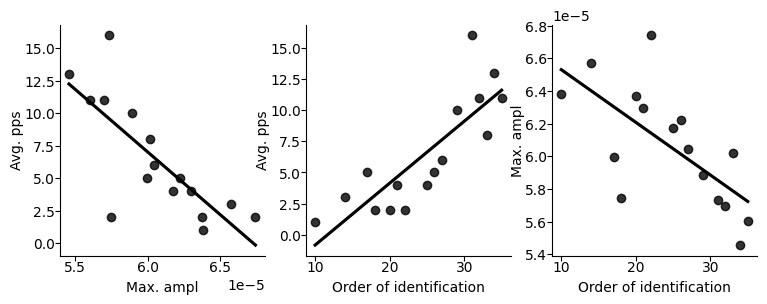

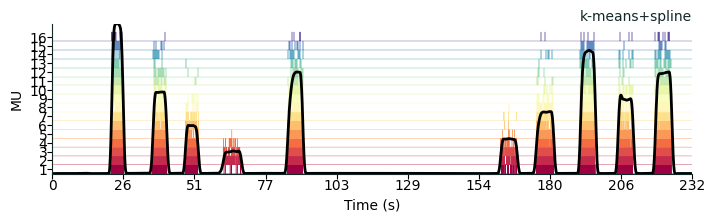

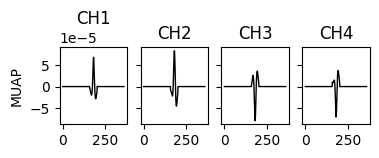

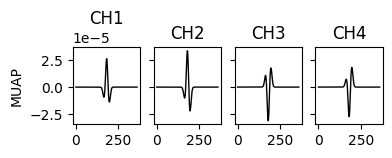

In [12]:
# Plot results
if MU_FOUND > 0:

    try:
        plot_regression(results_save_path, res)
    except Exception as e:
        print(e)

    try:
        plot_raster(results_save_path, FS, TS, SOURCES_INFO, FORCE_CHANNEL,
                    cluster_method, extension_method)
    except Exception as e:
        print(e)

    try:
        plot_ap_raw(results_save_path, CH, FS, MU_FOUND, DATA_FILTERED,
                    SOURCES_INFO)
    except Exception as e:
        print(e)

    try:
        plot_ap_smooth(results_save_path, CH, FS, MU_FOUND, DATA_FILTERED,
                       SOURCES_INFO)
    except Exception as e:
        print(e)